The Idea of this notebook is to implement neggrad with the constraints of GEM. We want to be able to give a series of commands i.e. learn 1, learn 2 , unlearn 1 and it does the learning and unlearning respectively.

The only change we would need to do to implement neggrad consistency. This is easy, for the given tasks that are learnt, X and the task number y that we wish to unlearn, we ensure the constraint in GEM with task y is <= 0 while the rest are >= 0 as the same as it would usually be. 

The hard part of this is ensuring consistency w.r.t the storing of gradients and memory buffers.

If we can do this we are done.

### Importing Libraries and Setting Up the Current Directory

Python 3.12.8
./cifar-100-python/train
./cifar-100-python/test


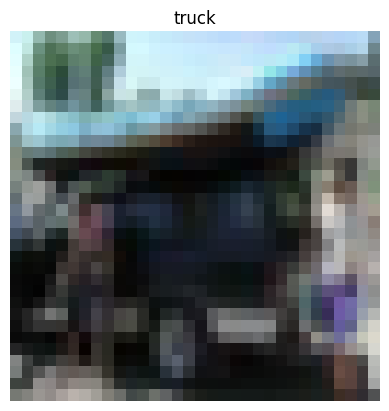

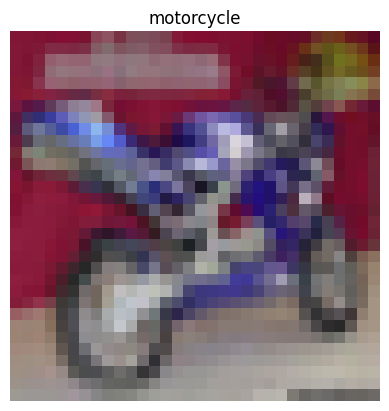

In [1]:
import os

os.system('nvidia-smi')

# run command to check oython version
os.system('python3.12 --version')

!pip3.12 install matplotlib


# set directory /dcs/large/u2145461/cs407/Machine-Unlearning-x-Continual-Learning
# please change these dependent on your own specific path variable

os.chdir('/dcs/large/u2145461/cs407/Machine-Unlearning-x-Continual-Learning-neggem')

save_path_1 = '/dcs/large/u2145461/cs407/Machine-Unlearning-x-Continual-Learning-neggem/GEM/Results4/'

save_path_2 = '/dcs/large/u2145461/cs407/Machine-Unlearning-x-Continual-Learning-neggem/GEM/Results/'

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
from cifar import load_cifar10_data, split_into_classes, get_class_indexes, load_data
import cifar
from torch.utils.data import DataLoader
import random

import sys
sys.path.append(os.path.abspath("."))  # Adds the current directory
# from GEM.gem import *
from GEM.args import *
from torch.nn.functional import relu, avg_pool2d
import torch.nn as nn
import quadprog

# we provide some top level initial parameters depending on if we want to work in cifar-10 or cifar-100

AGEM = True
PRETRAIN = 0 # number of initial classes to pretrain on
# Globals 
DATASET = 'cifar-100'
DATASET_PATH = 'cifar-100-python' 
CLASSES = cifar.CLASSES
SHUFFLEDCLASSES = CLASSES.copy()
CONFIDENCE_SAMPLES = 5
if DATASET == 'cifar-10':
    CLASSES = cifar.CLASSES
    CLASSES = CLASSES.copy()
elif DATASET == 'cifar-100':
    CLASSES = cifar.CLASSES_100_UNORDERED
    SHUFFLEDCLASSES = CLASSES.copy()




### Define the ResNet18 Model

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# C

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, nf):
        super(ResNet, self).__init__()
        self.in_planes = nf
        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        bsz = x.size(0)
        out = relu(self.bn1(self.conv1(x.view(bsz, 3, 32, 32))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(nclasses, nf=20):
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)

### The brains - here we define the memory facilities and the projections.

In [ ]:
def compute_offsets(task, nc_per_task, is_cifar):
    """
        Compute offsets for cifar to determine which
        outputs to select for a given task.
    """
    val1 = max(PRETRAIN - nc_per_task, 0)
    val2 = max(PRETRAIN - nc_per_task, 0)
    if task == 0:
        val1 = 0
        val2 = max(PRETRAIN - nc_per_task, 0)
    offset1 = task * nc_per_task + val1
    offset2 = (task + 1) * nc_per_task + val2    
    return offset1, offset2


def store_grad(pp, grads, grad_dims, tid):
    """
        This stores parameter gradients of past tasks.
        pp: parameters
        grads: gradients
        grad_dims: list with number of parameters per layers
        tid: task id
    """
    # store the gradients
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1


def overwrite_grad(pp, newgrad, grad_dims):
    """
        This is used to overwrite the gradients with a new gradient
        vector, whenever violations occur.
        pp: parameters
        newgrad: corrected gradient
        grad_dims: list storing number of parameters at each layer
    """
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1


def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    """
        Solves the GEM dual QP described in the paper given a proposed
        gradient "gradient", and a memory of task gradients "memories".
        Overwrites "gradient" with the final projected update.

        input:  gradient, p-vector
        input:  memories, (t * p)-vector
        output: x, p-vector
    """
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))

def agemprojection(gradient, gradient_memory, margin=0.5, eps=1e-5):
    """
    Projection of gradients for A-GEM with the memory approach
    Use averaged gradient memory for projection
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """

    gref = gradient_memory.t().double().mean(axis=0).cuda() # * margin
    g = gradient.contiguous().view(-1).double().cuda()

    dot_prod = torch.dot(g, gref)
    
    #if dot_prod < 0:
    #    x = g
    #    gradient.copy_(torch.Tensor(x).view(-1, 1))
    #    return
    
    # avoid division by zero
    dot_prod = dot_prod/(torch.dot(gref, gref))
    
    # epsvector = torch.Tensor([eps]).cuda()
    
    x = g*0.5 + gref * abs(dot_prod)  # + epsvector
    gradient.copy_(torch.Tensor(x).view(-1, 1))
    
def replay(gradient, gradient_memory):
    """
    Adds the gradients of the current task to the memory 
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """
    g = gradient_memory.t().double().sum(axis=0).cuda()
    gref = gradient.contiguous().view(-1).double().cuda()
    # simply add the gradients
    x = g + gref
    gradient.copy_(torch.Tensor(x).view(-1, 1))
    
def naiveretraining(gradient):
    """
    Naive retraining of the model on the current task
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """
    g = gradient.t().double().mean(axis=0).cuda()
    gradient.copy_(torch.Tensor(g).view(-1, 1))

class Net(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 args):
        super(Net, self).__init__()
        nl, nh = args.n_layers, args.n_hiddens
        self.margin = args.memory_strength
        self.net = ResNet18(n_outputs)


        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs

        self.opt = torch.optim.SGD(self.parameters(), args.lr)

        self.n_memories = args.n_memories
        self.gpu = args.cuda
        

        """
        Allocate episodic memory
        n_tasks: number of tasks
        n_memories: number of memories per task
        n_inputs: number of input features
        """

        # allocate episodic memory
        self.memory_data = torch.FloatTensor(
            n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)
        if args.cuda:
            self.memory_data = self.memory_data.cuda()
            self.memory_labs = self.memory_labs.cuda()

        # allocate temporary synaptic memory
        """ This is the memory that stores the gradients of the parameters of the network
            FOR each task. This is used to check for violations of the GEM constraint
            Assume:

            The model has 3 parameters with sizes 100, 200, and 300 elements respectively.
            n_tasks = 5 (number of tasks).
            The allocated tensors would have the following shapes:

            self.grad_dims: [100, 200, 300]
            self.grads: Shape [600, 5] (600 is the sum of 100, 200, and 300).
        """
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)
        if args.cuda:
            self.grads = self.grads.cuda()

        # allocate counters
        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        minus = 0
        if PRETRAIN > 0:
            minus = 1
        else: 
            minus = 0
        self.nc_per_task = int((n_outputs - PRETRAIN) / (n_tasks - minus))

    def forward(self, x, t):
        output = self.net(x)
        if t == -1:
            return output
        # make sure we predict classes within the current task
        val1 = 0
        val2 = 0
        if t != 0:
            val1 = max(PRETRAIN - self.nc_per_task, 0)
            val2 = val1
        else:
            val1 = 0
            val2 = max(PRETRAIN - self.nc_per_task, 0)                                                 
        offset1 = int(t * self.nc_per_task + val1) #t = 0 0, 5 -----t = 1 5 , 6 ## t = 0 0 ,5 --- t =1 5, 7
        offset2 = int((t + 1) * self.nc_per_task + val2) 
        if offset1 > 0:
            output[:, :offset1].data.fill_(-10e10)
        if offset2 < self.n_outputs:
            output[:, offset2:self.n_outputs].data.fill_(-10e10)
        return output

    def observe(self, algorithm, x, t, y):
        # update memory
        if t != self.old_task or t not in self.observed_tasks:
            self.observed_tasks.append(t)
            self.old_task = t
            
        val = 0
        if t == 0:
            val = max(PRETRAIN,1)
        else:
            val = 1
        # Update ring buffer storing examples from current task
        bsz = y.data.size(0)
        if (algorithm == 'NAIVE'):
            self.zero_grad()
            loss = self.ce(self.forward(x, t), y)
            loss.backward()
            self.opt.step()
            return
        
        endcnt = min(self.mem_cnt + bsz, self.n_memories) #256
        effbsz = endcnt - self.mem_cnt # 256
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        # compute gradient on previous tasks
        # if PRETRAIN == 0:
        #     val = 1
        # else:
        #     val = 0
        if len(self.observed_tasks) > 0: ### CHANGED FROM 1 to 0 SINCE WE PRETRAIN ON FST 5 CLASSES 
            for tt in range(len(self.observed_tasks) -1): ### CHANGED FROM -1 to -0 SINCE WE PRETRAIN ON FST 5 CLASSES 
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]
                
                offset1, offset2 = compute_offsets(past_task, self.nc_per_task,
                                                self.is_cifar)
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                        past_task)

        # now compute the grad on the current minibatch
        self.zero_grad()

        offset1, offset2 = compute_offsets(t, self.nc_per_task, self.is_cifar) 
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # check if gradient violates constraints
        if len(self.observed_tasks) > 0: ### CHANGED FROM 1 to 0 SINCE WE PRETRAIN ON FST 5 CLASSES 
            if algorithm == 'AGEM':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                                self.grads.index_select(1, indx))
                if (dotp < 0).sum() != 0:
                    agemprojection(self.grads[:, t].unsqueeze(1), self.grads.index_select(1, indx), self.margin)
                    # copy gradients back
                    overwrite_grad(self.parameters, self.grads[:, t],
                                self.grad_dims)
            # copy gradient
            elif algorithm == 'GEM':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                                self.grads.index_select(1, indx))
                if (dotp < 0).sum() != 0:
                    project2cone2(self.grads[:, t].unsqueeze(1),
                                self.grads.index_select(1, indx), self.margin)
                    # copy gradients back
                    overwrite_grad(self.parameters, self.grads[:, t],
                                self.grad_dims)
            elif algorithm == 'REPLAY':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                replay(self.grads[:, t].unsqueeze(1), self.grads.index_select(1, indx))
                # copy gradients back
                overwrite_grad(self.parameters, self.grads[:, t],
                            self.grad_dims)
        self.opt.step()


    def unlearn(self, algorithm, t, x1, x2, alpha = 0.9):
        
        ## first check if task t has been learned
        if t not in self.observed_tasks:
            print("Task , ", t, " has not been learned yet - No change")
            return

        ## now check if the task is not the first task learned 
        if len(self.observed_tasks) == 1:
            print("Only one task has been learned - resetting the model")
            self.reset()
            return
        
        if algorithm == 'neggem':
            ## otherwise we need to unlearn the task 
            ## we compute the gradients of all learnt tasks
            current_grad = []
            for param in self.parameters():
                if param.grad is not None:
                    current_grad.append(param.grad.data.view(-1))
            current_grad = torch.cat(current_grad).unsqueeze(1)


            # now find the grads of the previous tasks
            for tt in range(t + 1):
                self.zero_grad()
                past_task = self.observed_tasks[tt]
                offset1, offset2 = compute_offsets(past_task, self.nc_per_task,
                                                    self.is_cifar)
                ptloss = self.ce(
                        self.forward(
                            self.memory_data[past_task],
                            past_task)[:, offset1: offset2],
                        self.memory_labs[past_task] - offset1)
                if tt == t:
                    ptloss = self.ce(
                        self.forward(
                            self.memory_data[past_task][x1:x2],
                            past_task)[:, offset1: offset2],
                        self.memory_labs[past_task][x1:x2] - offset1)
                    
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                            past_task)

            
            ## so now, we have the gradients of all the tasks we can now do our projection,
            ## first we check if it is even neccessary to do so, if not simply do a optimiser.step()
        
            forget_grads = self.grads[:, t].unsqueeze(1).clone().t()
            retain_indices = torch.tensor([i for i in range(self.grads.size(1)) if i in self.observed_tasks and i < t], device=self.grads.device)
            retain_grads = self.grads.index_select(1, retain_indices).t()


            project2cone2_neggrad_dual(current_grad, forget_grads, retain_grads, self.margin)
            overwrite_grad(self.parameters, current_grad, self.grad_dims)
            # set the opt learning rate to the unlearn rate
            #self.opt = torch.optim.SGD(self.parameters(), 0.01)
            self.opt.step()
        elif algorithm == "neggrad":
            """
            for tt in range(len(self.observed_tasks)):
                output_clean = self.forward(input)
                del_output_clean = self.forward(del_input)
                r_loss = self.ce(output_clean, target)
                del_loss = self.ce(del_output_clean, del_target)

                loss = alpha*r_loss - (1-alpha)*del_loss

                # Backward
                self.zero_grad()
                loss.backward()
                self.step()

                loss = loss.float()
            """

            for tt in range(len(self.observed_tasks)):
                past_task = self.observed_tasks[tt]
                offset1, offset2 = compute_offsets(past_task, self.nc_per_task, self.is_cifar)
                ptloss = self.ce(
                    self.forward(self.memory_data[past_task], past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                
                #store_grad(self.parameters, self.grads, self.grad_dims,
                #            past_task)
                    
                if past_task < t:
                    # apply neggrad constraint take into account the alpha value
                    ptloss *= alpha
                else:
                    ptloss *= -1*(1-alpha)
                self.zero_grad()
                ptloss.backward()
                self.opt.step()
                
                
        else:
            print("Invalid Algorithm")

def project2cone2_neggrad_alt(gradient, forget_memories, retain_memories, margin=0.5, eps=1e-3):
    """
    Projects 'gradient' onto the set of feasible gradients that:
      1) Have dot product with each forget_mem <= -margin.
      2) Have dot product with each retain_mem >= margin.
      3) Are as close as possible in L2 norm to the original 'gradient'.

    Args:
        gradient (torch.Tensor): p-dimensional gradient vector to be projected.
        forget_memories (torch.Tensor): shape (f, p) with f "forget" memories.
        retain_memories (torch.Tensor): shape (r, p) with r "retain" memories.
        margin (float): margin for each dot-product constraint.
        eps (float): small positive scalar for numerical stability in quadratic programming.

    Returns:
        Nothing, but 'gradient' is modified in place to be the projected gradient.
    """

    # Convert inputs to NumPy arrays.
    g = gradient.detach().cpu().contiguous().view(-1).double().numpy()
    F = forget_memories.detach().cpu().double().numpy()       # shape (f, p)
    R = retain_memories.detach().cpu().double().numpy()       # shape (r, p)
    p_dim = g.shape[0]

    f_count = F.shape[0]
    if f_count > 0:
        # Quadratic term
        P_forget = F @ F.T
        P_forget = 0.5 * (P_forget + P_forget.T)  # ensure symmetry
        P_forget += eps * np.eye(f_count)         # numerical stability

        # Linear term
        q_forget = F @ g
        q_forget = -1.0 * q_forget  # objective is 1/2 λ^T P λ + q^T λ

        G_forget = -np.eye(f_count)  # λ >= 0 => -λ <= 0
        h_forget = np.zeros(f_count)
        
        # Solve the QP
        λ_forget, _, _, _, _, _ = quadprog.solve_qp(P_forget, q_forget, G_forget.T, h_forget)
        # Compute the partial projection
        x_forget = g + (F.T @ λ_forget)
    else:
        x_forget = g  # no forget constraints

    # Next, incorporate 'retain' constraints similarly. 
    r_count = R.shape[0]
    if r_count > 0:
        # We'll do a separate solve for demonstration, though in practice you'd combine them. 
        P_retain = R @ R.T
        P_retain = 0.5 * (P_retain + P_retain.T)
        P_retain += eps * np.eye(r_count)

        q_retain = R @ x_forget
        q_retain = -1.0 * q_retain

        G_retain = -np.eye(r_count)
        h_retain = np.zeros(r_count)

        λ_retain, _, _, _, _, _ = quadprog.solve_qp(P_retain, q_retain, G_retain.T, h_retain)
        x_final = x_forget + (R.T @ λ_retain)
    else:
        x_final = x_forget

    # Done – in a real usage you would incorporate the margin directly and unify 
    # the constraints. This snippet just demonstrates an alternate code shape 
    # rather than exactly matching your setup.

    # Move x_final back into 'gradient'.
    gradient.copy_(torch.from_numpy(x_final.reshape(-1, 1)).to(gradient.device))



def project2cone2_neggrad_dual(gradient, forget_memories, retain_memories,
                                margin=1.0, eps=1e-5):
    """
    Dual QP approach to enforce:
    1) f_i^T x <= -margin for each forget_mem f_i
    2) r_j^T x >=  margin for each retain_mem r_j
    while minimising ||x - g||^2 in L2.

    This solves in O((f+r)^3) time rather than O(p^3), making it much more
    efficient if (f+r) << p.

    Args:
        gradient (torch.Tensor): shape (p,) or (p,1), the original gradient g.
        forget_memories (torch.Tensor): shape (f, p) of "forget" vectors f_i.
        retain_memories (torch.Tensor): shape (r, p) of "retain" vectors r_j.
        margin (float): margin for dot-products.
        eps (float): small constant for numerical stability in the matrix P.

    Returns:
        None. The 'gradient' tensor is updated in place to the projected x.
    """
    
    try:
        # ---- 1) Prepare data as NumPy arrays ----
        g = gradient.detach().cpu().contiguous().view(-1).double().numpy()  # shape (p,)
        F = forget_memories.detach().cpu().double().numpy()  # shape (f, p)
        R = retain_memories.detach().cpu().double().numpy()  # shape (r, p)

        f_count = F.shape[0]
        r_count = R.shape[0]
        

        # ---- 2) Build the matrix A of shape (f+r, p). 
        # Rows 0..f-1 => -F[i], rows f..f+r-1 => R[j].
        A_forget = -F  # shape (f, p)
        A_retain =  R  # shape (r, p)
        A = np.concatenate([A_forget, A_retain], axis=0)  # shape ((f+r), p)

        P = A @ A.T  # shape (f+r, f+r)
        # Add eps * I for numerical stability
        P = 0.5 * (P + P.T) + eps*np.eye(f_count + r_count)

        n_vars = f_count + r_count  # dimension of lambda
        n_cons = 2*(f_count + r_count)

        # G is shape (n_vars, n_cons). We'll fill columns one by one (since quadprog uses G^T x >= h).
        G = np.zeros((n_vars, n_cons), dtype=np.double)
        h = np.zeros(n_cons, dtype=np.double)

        # (a) positivity constraints
        for i in range(n_vars):
            # e_i^T lambda >= 0 => \lambda_i >= 0
            # That means G[:, c] is e_i => G[i, c] = 1
            G[i, i] = 1.0
            h[i] = 0.0

        # (b) dot-product constraints
        for i in range(n_vars):
            # constraint index c in the second block
            c = n_vars + i

            a_i = A[i, :]          # shape (p,)
            b_i = margin - np.dot(a_i, g)

            G[:, c] = A @ a_i      # shape (n_vars,)

            # h[c] = b_i
            h[c] = b_i

        q = np.zeros(n_vars, dtype=np.double)
        sol, f_val, _, _, _, _ = quadprog.solve_qp(P, q, G, h, meq=0)

        # ---- 6) Reconstruct x = g + A^T lambda ----
        x_star = g + A.T @ sol  # shape (p,)

        # ---- 7) Copy back into 'gradient' ----
        x_torch = torch.from_numpy(x_star).reshape(-1, 1).to(gradient.device)
        gradient.copy_(x_torch)
    except:
        margin /= 2
    
    def apply_Salun(model, threshold):
        '''
        Apply's SalUn to the model
        for the current gradients it has.
        '''
        
        for param in model.parameters():
            if param.grad is not None:
                # Get the gradient and preserve original shape
                original_shape = param.grad.data.shape
                grad = param.grad.data.view(-1)
                
                # Check if the gradient norm is above the threshold
                if torch.norm(grad) > threshold:

                    """ Apply SalUn (soft thresholding) - Optional, interesting if we test!!!!"""
                    # grad = torch.sign(grad) * torch.clamp(torch.abs(grad) - threshold, min=0)
                    
                    # Restore original shape
                    param.grad.data = grad.view(original_shape)
                else:
                    # Set the gradient to zero
                    param.grad.data.zero_()
        
        return model


NameError: name 'nn' is not defined

# Continuum Learning (TIL)

## Key Steps

1. **Model Initialization**:
   - Initializes the neural network `model` using the specified number of inputs, outputs, and tasks.
   - Moves the model to CUDA if enabled in the arguments.

2. **Data Preparation**:
   - Loads the CIFAR dataset and shuffles the class labels according to the specified new order (`newclasses`).
   - Maps the old class labels to their new ordering.
   - Splits the dataset into pretraining and task-specific subsets:
     - Pretraining data is used if `PRETRAIN > 0`.
     - The remaining data is partitioned into tasks of size `size_of_task`.

3. **Training Loop**:
   - Iterates through each task, training the model on its corresponding data.
   - For each epoch:
     - Divides the task's data into batches and trains the model using the `observe` method.
   - Tests the model after each epoch and stops early if the training accuracy exceeds 75%.

4. **Testing**:
   - Evaluates the trained model on the test data for all tasks.
   - Computes:
     - **Test accuracy**: The fraction of correct predictions for each task.
     - **Average confidence scores**: The mean confidence of the model's predictions (using softmax probabilities).

5. **Return Values**:
   - The function returns:
     - The trained model.
     - A list of test accuracies for all tasks.
     - A list of average confidence scores for each task.


In [ ]:
def eval_retain_forget_test(model, args, retain_set, forget_set, test_set, retain_acc, forget_acc, test_acc, test_acc_forget):
    test_bs = 1000
    correct_retain = 0
    total_retain = 0
    for i in range(0, len(retain_set)):
        correct = 0
        total = len(retain_set[i])     

        # Test the model
        
        x = torch.Tensor(retain_set[i][0].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(retain_set[i][1]).long()
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        model.eval()
        correct = 0
        total = len(retain_set[i][0])
        for j in range(0,len(retain_set[i][0]), test_bs):
            current_data = x[j: j + test_bs]
            current_labels = y[j: j + test_bs]
            output = model.forward(current_data, i)
            pred = output.data.max(1)[1]
            correct += (pred == current_labels).sum().item()
        correct_retain += correct
        total_retain += total
    print("Total correct retain: ", correct_retain, " Total retain: ", total_retain)
    
    retain_acc.append(correct_retain / total_retain)
    
    correct_forget = 0
    total_forget = 0
    for i in range(0, len(forget_set)):
        correct = 0
        total = len(forget_set[i])     

        # Test the model
        
        x = torch.Tensor(forget_set[i][0].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(forget_set[i][1]).long()
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        model.eval()
        total = len(forget_set[i][0])
        for j in range(0,len(forget_set[i][0]), test_bs):
            current_data = x[j: j + test_bs]
            current_labels = y[j: j + test_bs]
            output = model.forward(current_data, i + len(retain_set))
            pred = output.data.max(1)[1]
            correct += (pred == current_labels).sum().item()
        correct_forget += correct
        total_forget += total
    print("Total correct forget: ", correct_forget, " Total forget: ", total_forget)
    
    forget_acc.append(correct_forget / total_forget)
    
    correct_test = 0
    total_test = 0
    
    for i in range(0, 2 * len(retain_set), 2):
        correct = 0
        total = len(test_set[i])     

        # Test the model
        
        x = torch.Tensor(test_set[i].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(test_set[i+1]).long()
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        model.eval()
        average_confidence_task = []
        # keep track of average confidence score
        for j in range(0,len(test_set[i]), test_bs):
            current_data = x[j: j + test_bs]
            current_labels = y[j: j + test_bs]
            output = model.forward(current_data, i // 2)
            pred = output.data.max(1)[1]
            correct += (pred == current_labels).sum().item()
        correct_test += correct
        total_test += total
    print("Total correct test: ", correct_test, " Total test: ", total_test)
        
    test_acc.append(correct_test/total_test)
    
    correct_test_forget = 0
    total_test_forget = 0
    for i in range(2 * len(retain_set), 2 * (len(retain_set) + len(forget_set)),  2):
        correct = 0
        total = len(test_set[i])     

        # Test the model
        
        x = torch.Tensor(test_set[i].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(test_set[i+1]).long()
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        model.eval()
        average_confidence_task = []
        # keep track of average confidence score
        for j in range(0,len(test_set[i]), test_bs):
            current_data = x[j: j + test_bs]
            current_labels = y[j: j + test_bs]
            output = model.forward(current_data, i // 2)
            pred = output.data.max(1)[1]
            correct += (pred == current_labels).sum().item()
        correct_test_forget += correct
        total_test_forget += total
        
    test_acc_forget.append(correct_test_forget/total_test_forget)
    
    print("Total correct forget test: ", correct_test_forget, " Total test forget: ", total_test_forget)
        
    return retain_acc, forget_acc, test_acc, test_acc_forget

# define main function to run on the cifar dataset
N_TASKS = 20 #[2 tasks [airplane, automobile, etc], [dog , frog, etc]]
SIZE_OF_TASKS = 5
N_OUTPUTS = 100
N_INPUTS = 32 * 32 * 3
def run_cifar(algorithm, args, n_inputs=N_INPUTS, n_outputs=N_OUTPUTS, n_tasks=N_TASKS, size_of_task=SIZE_OF_TASKS, newclasses = SHUFFLEDCLASSES):
    # Set up the model
    model = Net(n_inputs, n_outputs, n_tasks, args)
    if args.cuda:
        model.cuda()
    model.is_cifar = True
    test_bs = 1000
    print(args.batch_size)
    test_accuracies = []

    # Load data
    train_data, train_labels, test_data, test_labels = load_data(DATASET_PATH, DATASET)
    ## NEWCLASSES = shuffled CLASSES
    NEWCLASSES = newclasses
    print("new ordering of classes: ", NEWCLASSES)
    oldClasstoNewClass = {}
    for i in range(len(CLASSES)):
        oldClasstoNewClass[i] = NEWCLASSES.index(CLASSES[i])
    for i in range(len(train_labels)):
        train_labels[i] = oldClasstoNewClass[train_labels[i]]
    for i in range(len(test_labels)):
        test_labels[i] = oldClasstoNewClass[test_labels[i]]

    pretrain_classses = NEWCLASSES[:PRETRAIN]
    pretrain_data, pretrain_labels = split_into_classes(train_data, train_labels, pretrain_classses, NEWCLASSES)
    pretest_data, pretest_labels = split_into_classes(test_data, test_labels, pretrain_classses, NEWCLASSES)
    tasks = []
    tests = []
    if PRETRAIN > 0:
        tasks = [[pretrain_data, pretrain_labels]]
        tests = [pretest_data, pretest_labels]
    else:

        tasks = []
        tests = []
    for i in range(n_tasks):
        if i == 0 and PRETRAIN > 0: ## as task 1 we already grab from 
            continue
        ## Since we have already pretrain on the first x classes, we need to offset our counter by x to learn the next set of classes
        elif PRETRAIN > 0:
            task_data, task_labels = split_into_classes(train_data, train_labels, NEWCLASSES[PRETRAIN + size_of_task * (i-1) : PRETRAIN + size_of_task * (i)], NEWCLASSES)
            tasks.append([task_data, task_labels])
            partition_test_data, partition_test_labels = split_into_classes(test_data, test_labels, NEWCLASSES[PRETRAIN + size_of_task * (i-1) : PRETRAIN + size_of_task * (i)], NEWCLASSES)
            tests.append(partition_test_data)
            tests.append(partition_test_labels)
        ## no pretraining, carry on as normal
        else:
            task_data, task_labels = split_into_classes(train_data, train_labels, NEWCLASSES[size_of_task * i : size_of_task * (i + 1)] , NEWCLASSES)
            tasks.append([task_data, task_labels])
            partition_test_data, partition_test_labels = split_into_classes(test_data, test_labels, NEWCLASSES[size_of_task * i : size_of_task * (i + 1)] , NEWCLASSES)
            tests.append(partition_test_data)
            tests.append(partition_test_labels)

    # Train the model
    for task in range(n_tasks):
        print("Training task: ", task  + 1)
        
        x = torch.Tensor(tasks[task][0].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(tasks[task][1]).long()
        
        if args.cuda:
            x, y = x.cuda(), y.cuda()
    
        for epoch in range(args.n_epochs):
            for j in range(0, len(tasks[task][0]), args.batch_size):
                current_data = x[j: j + args.batch_size]
                current_labels = y[j: j + args.batch_size]
                model.train()
                model.observe(algorithm, current_data, task, current_labels)
            
            #test the model after each epoch
            correct = 0
            total = len(tasks[task][0])
            for j in range(0,len(tasks[task][0]), test_bs):
                current_data = x[j: j + test_bs]
                current_labels = y[j: j + test_bs]
                output = model.forward(current_data, task)
                pred = output.data.max(1)[1]

            if correct / total > 0.85:
                break
            #   output loss only


    # Test the model after training
        average_confidence = []
        for i in range(0, len(tests), 2):
            correct = 0
            total = len(tests[i])     

            # Test the model
            
            x = torch.Tensor(tests[i].reshape(-1, 32*32*3)).float()
            y = torch.Tensor(tests[i+1]).long()
            if args.cuda:
                x, y = x.cuda(), y.cuda()
            model.eval()
            average_confidence_task = []
            # keep track of average confidence score
            for j in range(0,len(tests[i]), test_bs):
                current_data = x[j: j + test_bs]
                current_labels = y[j: j + test_bs]
                output = model.forward(current_data, i // 2)
                # apply softmax to get predictions
                probabilities = torch.nn.functional.softmax(output, dim=1)
                # get the maximum value of the probabilities for each image
                predicted = torch.max(probabilities, 1).values
                # get the average confidence score of the batch
                average_confidence_task.append(torch.mean(predicted).item())
                
                pred = output.data.max(1)[1]
                correct += (pred == current_labels).sum().item()

            test_accuracies.append(correct / total)
            average_confidence.append(sum(average_confidence_task) / len(average_confidence_task))  
    
    unlearning_algo = "neggem"
    ## after training lets unlearn the last task and test the model again
    print("Unlearning task: ", n_tasks)
    
    retain_set = tasks[:1]
    forget_set = tasks[-19:]
    test_set = tests
    
    retain_accuracies = []
    
    forget_accuracies = []
    testing_accuracies = []
    
    testing_accuracies_forget = []
    
    # set the optimiser lr to 0.01
    
    model.opt = torch.optim.SGD(model.parameters(), args.unlearning_rate)
    
    retain_accuracies, forget_accuracies, testing_accuracies, testing_accuracies_forget = eval_retain_forget_test(model, args,
                                                        retain_set, forget_set, test_set, retain_accuracies, forget_accuracies,
                                                        testing_accuracies, testing_accuracies_forget)
    
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]: # 
        #torch.cuda.empty_cache()
        model.train()
        for epoch in range(args.unlearn_epochs):
            for j in range(0, args.n_memories, args.unlearn_batch_size):
                model.unlearn(unlearning_algo, n_tasks - i, x1 = j, x2 = j + args.unlearn_batch_size)

        model.observed_tasks = model.observed_tasks[:-1]
        
        model.eval()
        retain_accuracies, forget_accuracies, testing_accuracies, testing_accuracies_forget = eval_retain_forget_test(model, args,
                                                            retain_set, forget_set, test_set, retain_accuracies, forget_accuracies,
                                                            testing_accuracies, testing_accuracies_forget)
        
        
    after_unlearn_accuracies = []
    average_confidence_after_unlearn = []
    for i in range(0, len(tests), 2):
        correct = 0
        total = len(tests[i])     

        # Test the model
        
        x = torch.Tensor(tests[i].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(tests[i+1]).long()
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        model.eval()
        average_confidence_task = []
        # keep track of average confidence score
        for j in range(0,len(tests[i]), test_bs):
            current_data = x[j: j + test_bs]
            current_labels = y[j: j + test_bs]
            output = model.forward(current_data, i // 2)
            # apply softmax to get predictions
            probabilities = torch.nn.functional.softmax(output, dim=1)
            # get the maximum value of the probabilities for each image
            predicted = torch.max(probabilities, 1).values
            # get the average confidence score of the batch
            average_confidence_task.append(torch.mean(predicted).item())
            
            pred = output.data.max(1)[1]
            correct += (pred == current_labels).sum().item()

        after_unlearn_accuracies.append(correct / total)
        average_confidence_after_unlearn.append(sum(average_confidence_task) / len(average_confidence_task))
    return model, test_accuracies, average_confidence , after_unlearn_accuracies, average_confidence_after_unlearn, retain_accuracies, forget_accuracies, testing_accuracies, testing_accuracies_forget

# sample usage
# model, test_accuracies = run_cifar(Args())

100
cifar-100-python/train
cifar-100-python/test
new ordering of classes:  ['clock', 'chair', 'cloud', 'plain', 'cattle', 'bus', 'butterfly', 'boy', 'shark', 'bed', 'shrew', 'mushrooms', 'beaver', 'squirrel', 'flatfish', 'fox', 'mouse', 'apples', 'crocodile', 'snail', 'forest', 'tulips', 'snake', 'cups', 'computer keyboard', 'dinosaur', 'lamp', 'beetle', 'sunflowers', 'lizard', 'skyscraper', 'wolf', 'porcupine', 'bear', 'streetcar', 'ray', 'lawn-mower', 'sweet peppers', 'turtle', 'cans', 'mountain', 'tiger', 'oranges', 'baby', 'poppies', 'camel', 'girl', 'dolphin', 'castle', 'kangaroo', 'palm', 'hamster', 'road', 'pears', 'raccoon', 'telephone', 'maple', 'sea', 'man', 'table', 'rabbit', 'pine', 'lobster', 'tank', 'oak', 'otter', 'trout', 'woman', 'crab', 'motorcycle', 'roses', 'house', 'train', 'aquarium fish', 'plates', 'chimpanzee', 'caterpillar', 'elephant', 'whale', 'worm', 'pickup truck', 'spider', 'bicycle', 'bottles', 'couch', 'television', 'cockroach', 'willow', 'seal', 'bridge

/tmp/dcs-tmp.u2145461/ipykernel_403031/1027086851.py:291: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \


Training task:  2
Training task:  3
Training task:  4
Training task:  5
Training task:  6
Training task:  7
Training task:  8
Training task:  9
Training task:  10
Training task:  11
Training task:  12
Training task:  13
Training task:  14
Training task:  15
Training task:  16
Training task:  17
Training task:  18
Training task:  19
Training task:  20
Unlearning task:  20
Total correct retain:  1690  Total retain:  2500
Total correct forget:  34991  Total forget:  47500
Total correct test:  327  Total test:  500
Total correct forget test:  6100  Total test forget:  9500
Total correct retain:  1651  Total retain:  2500
Total correct forget:  28561  Total forget:  47500
Total correct test:  324  Total test:  500
Total correct forget test:  5371  Total test forget:  9500
Total correct retain:  1599  Total retain:  2500
Total correct forget:  26738  Total forget:  47500
Total correct test:  304  Total test:  500
Total correct forget test:  5145  Total test forget:  9500
Total correct retain

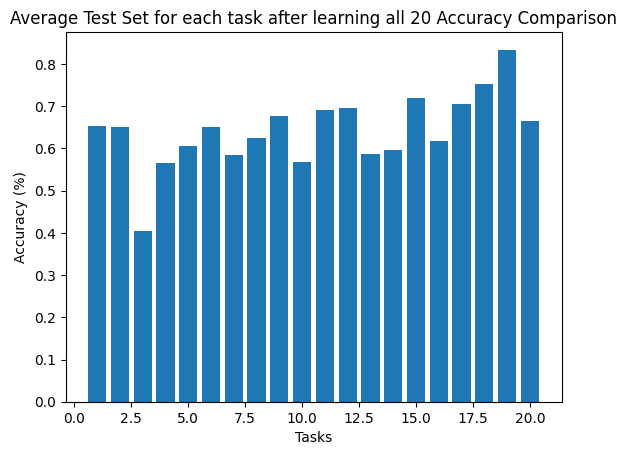

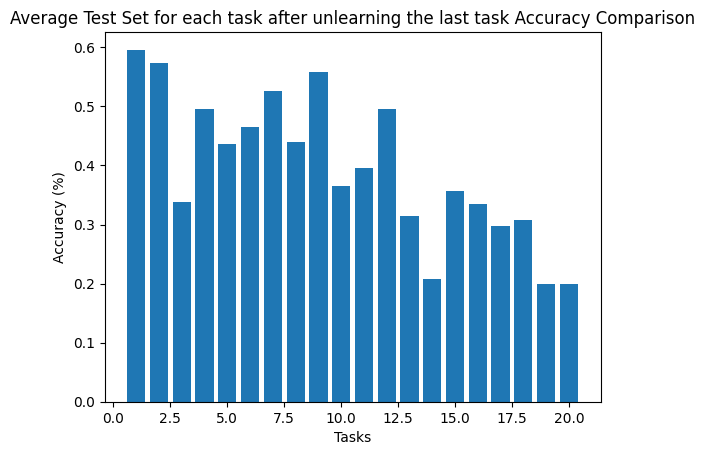

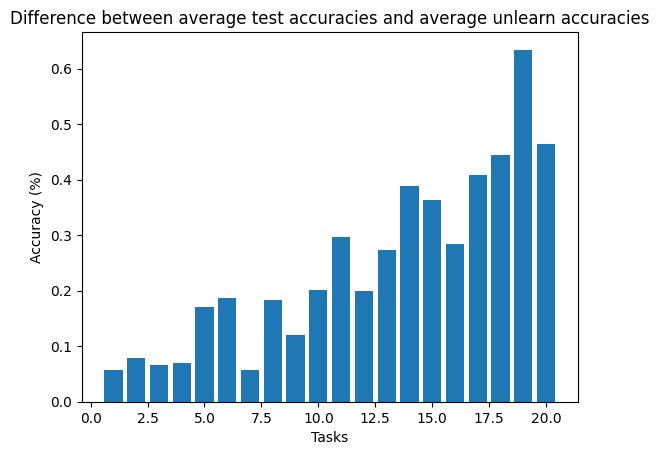

In [5]:
test_accuracies_GEM_all_last_iter = []
unlearn_accuracies_GEM_all_last_iter = []

retain_accuracies_all = []
forget_accuracies_all = []
testing_accuracies_all = []
testing_accuracies_forget_all = []

iternumb = 0
while len(test_accuracies_GEM_all_last_iter) < 1:
    iternumb += 1
    torch.cuda.empty_cache()
    random.shuffle(SHUFFLEDCLASSES)

    model, test_accuracies_GEM, confidence , after_unlearn_acc, after_unlearn_conf, retain_accuracies, forget_accuracies, testing_accuracies, testing_accuracies_forget = run_cifar('GEM', Args())

    test_accuracies_GEM_all_last_iter.append(test_accuracies_GEM[-20:])
    unlearn_accuracies_GEM_all_last_iter.append(after_unlearn_acc)
    retain_accuracies_all.append(retain_accuracies)
    forget_accuracies_all.append(forget_accuracies)
    testing_accuracies_all.append(testing_accuracies)
    testing_accuracies_forget_all.append(testing_accuracies_forget)

## average column-wise the test accuracies 
average_test_accuracies_GEM = np.mean(test_accuracies_GEM_all_last_iter, axis=0)
average_unlearn_accuracies_GEM = np.mean(unlearn_accuracies_GEM_all_last_iter, axis=0)

retain_accuracies_avg = np.mean(retain_accuracies_all, axis = 0)
forget_accuracies_avg = np.mean(forget_accuracies_all, axis = 0)
testing_accuracies_avg = np.mean(testing_accuracies_all, axis = 0)
testing_accuracies_forget_avg = np.mean(testing_accuracies_forget_all, axis = 0)

plt.bar(range(1, 21), average_test_accuracies_GEM)
plt.title('Average Test Set for each task after learning all 20 Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Tasks')
plt.savefig('average_task_20_accuracy_comparison.png')
plt.show()

plt.bar(range(1, 21), average_unlearn_accuracies_GEM)
plt.title('Average Test Set for each task after unlearning the last task Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Tasks')
plt.savefig('average_task_20_accuracy_comparison_after_unlearning.png')
plt.show()

# plot the difference between the average test accuracies and the average unlearn accuracies
difference = average_test_accuracies_GEM - average_unlearn_accuracies_GEM
plt.bar(range(1, 21), difference)
plt.title('Difference between average test accuracies and average unlearn accuracies')
plt.ylabel('Accuracy (%)')
plt.xlabel('Tasks')
plt.savefig('average_difference_task_20_accuracy_comparison.png')
plt.show()


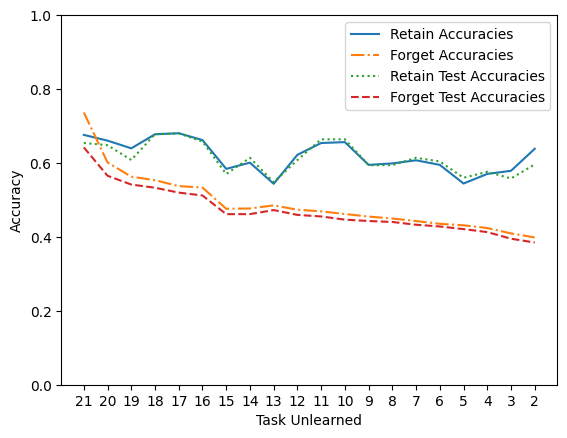

In [6]:
# Define your x values
x = [21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
#x = [21, 20]
# cuda function to flush the memory


# Convert each x value into a string label
x_labels = [str(xi) for xi in x]
#x = [0, 1]
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
# Plot your lines
plt.plot(x, retain_accuracies_avg, label="Retain Accuracies", linestyle="-")
plt.plot(x, forget_accuracies_avg, label="Forget Accuracies", linestyle="-.")
plt.plot(x, testing_accuracies_avg, label="Retain Test Accuracies", linestyle=":")
plt.plot(x, testing_accuracies_forget_avg, label="Forget Test Accuracies", linestyle="--")


# Set y-axis range
plt.ylim(0, 1)

# Add axis labels
plt.xlabel("Task Unlearned")
plt.ylabel("Accuracy")

# Use the custom string labels for the x-axis
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
#x = [0, 1]
plt.xticks(x, x_labels)

# Display legend and plot 
plt.legend()
plt.savefig('RetainForgetTest.png')
plt.show()